# Agentic RAG

In [54]:
import os
import pprint
from dotenv import load_dotenv
from typing import Annotated, Sequence, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from IPython.display import Image, display

load_dotenv()

from langchain_community.document_loaders import WebBaseLoader, csv_loader
from langchain_ollama import ChatOllama
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import Document

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain.tools.retriever import create_retriever_tool

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode



Il existe plusieurs leviers d'optimisation pour du deeplearning :
- la source -> le csv avec les metadata_columns et csv_args
- les chunks : chunk_size et chunk_overlap + ajout dans le contexte des 2 chunks précédents et 2 chunks suivants
- l'agent : faire vérifier l'output par un agent vérificateur

## Téléchargement du CSV

Arguments ajoutées pour que les métadonnées prennent en compte la date

In [55]:
loader = csv_loader.CSVLoader(
    file_path="datas/short_APPL.csv",
    metadata_columns=["date"], # add date as metadata
    encoding="utf-8",
    csv_args={
        "delimiter": ",",
        "quotechar": '"',
    })
docs = loader.load()

print(f"Loaded {len(docs)} documents from CSV file.")
print(f"First document metadata:\n{docs[0].metadata}")
print(f"First document content:\n{docs[0].page_content}")

Loaded 10 documents from CSV file.
First document metadata:
{'source': 'datas/short_APPL.csv', 'row': 0, 'date': '2023-12-16 22:00:00 UTC'}
First document content:
: 0
article: After an absolute disaster of a year in 2022, the stock market appears to have turned the corner. Each of the major market indexes has gained more than 20% from their respective trough. Perhaps more importantly, the S&P 500 and the Nasdaq Composite are within striking distance of new highs, which will check the final box marking the start of a new bull market.
Closing out the old and ringing in the new is a great time for examination, and one of the places I start is with my portfolio. A review of my top investments and how they came to be that way can offer valuable insight for the future.
Here's a look at my six largest holdings heading into 2024 (as of the market close on Dec. 15) and the incredibly valuable lesson I learned from each one.
Image source: Getty Images.
No. 6: Nvidia
Every investor has one -- th

## Encodage

split le document en chunks<br/>
et embedding avec un modèle HuggingFace

In [56]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100,
    chunk_overlap=50,
)
docs_splits = text_splitter.split_documents(docs)
print(f"Total chunks: {len(docs_splits)}")
print(f"First chunk: {docs_splits[0].page_content}")

Total chunks: 173
First chunk: : 0
article: After an absolute disaster of a year in 2022, the stock market appears to have turned the corner. Each of the major market indexes has gained more than 20% from their respective trough. Perhaps more importantly, the S&P 500 and the Nasdaq Composite are within striking distance of new highs, which will check the final box marking the start of a new bull market.


In [57]:
# Display the first 3 chunks
for chunk in docs_splits[:3]:
    print("Texte :", chunk.page_content)
    print("Date :", chunk.metadata.get("date"))
    print("------")

Texte : : 0
article: After an absolute disaster of a year in 2022, the stock market appears to have turned the corner. Each of the major market indexes has gained more than 20% from their respective trough. Perhaps more importantly, the S&P 500 and the Nasdaq Composite are within striking distance of new highs, which will check the final box marking the start of a new bull market.
Date : 2023-12-16 22:00:00 UTC
------
Texte : Closing out the old and ringing in the new is a great time for examination, and one of the places I start is with my portfolio. A review of my top investments and how they came to be that way can offer valuable insight for the future.
Here's a look at my six largest holdings heading into 2024 (as of the market close on Dec. 15) and the incredibly valuable lesson I learned from each one.
Image source: Getty Images.
No. 6: Nvidia
Date : 2023-12-16 22:00:00 UTC
------
Texte : Every investor has one -- the "stock that got away." The one you meant to buy, only to find 

## Contextualiser les chunks

In [58]:
def buid_contextual_chunks(chunks, window=2):
    """
    Build contextual chunks by combining text from neighboring chunks within a specified window.

    Args:
        chunks (list): List of Document objects to process.
        window (int): Number of neighboring chunks to include before and after the current chunk.

    Returns:
        list: List of Document objects with combined content and preserved metadata.
    """
    contextual_chunks = []
    for i in range(len(chunks)):
        # Determine the range of neighboring chunks to include
        start = max(i - window, 0)
        end = min(i + window + 1, len(chunks))
        
        # Combine the content of the current chunk and its neighbors
        combined_text = "\n".join([chunks[j].page_content for j in range(start, end)])
        
        # Copy metadata from the current chunk
        metadata = chunks[i].metadata.copy()
        
        # Create a new Document with combined content and metadata
        contextual_chunks.append(Document(page_content=combined_text, metadata=metadata))
    
    return contextual_chunks

# Generate contextualized documents by applying the function to the split documents
contextual_docs = buid_contextual_chunks(docs_splits)

In [59]:
# create embedding model
embedding_model = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2")

In [62]:
# create a folder to store the database
persist_directory = "./chroma_db"
os.makedirs(persist_directory, exist_ok=True)

In [63]:
# create vectorstore
vectorestore = Chroma.from_documents(
    documents=contextual_docs,
    collection_name="rag-chroma",
    embedding=embedding_model,
    persist_directory=persist_directory
)
retriever = vectorestore.as_retriever()

In [64]:
# create retriever tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_apple_news",
    "Search and return information from press articles about Apple Inc., including news related to its stock market activity, financial performance, and business developments.",
)
tools = [retriever_tool]

In [65]:
import chromadb
print(chromadb.__version__)

1.0.4


## Agent State

Création de la classe AgentState
création des différentes Edges

In [66]:
# create an agent to state messages
class AgentState(TypedDict):
   messages: Annotated[Sequence[BaseMessage], add_messages]

différentes fonctions

In [67]:
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Détermine si les documents récupérés sont pertinents par rapport à la question.
    
    Args :
        state (messages): L'état des messages du système.
        
    Returns :
        str: Une décision quant à savoir si les documents sont pertinents ou non
    """
    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Score binaire pour la vérification de la pertinence."""
        binary_score: str = Field(description="Score de pertinence 'yes' or 'no' " )

    # LLM
    model = ChatOllama(temperature=0, model="mistral", streaming=True)

    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
      
    # Chain
    chain = prompt | llm_with_tool

    # Add the message to the state
    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # score the documents
    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        state["next"] = "hallucinations_grader"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print("score = ", score)
        state["next"] = "rewrite"

    return state

In [70]:
# test ChatOllama mistral
chat = ChatOllama(model="mistral")
response = chat.invoke([HumanMessage(content="Bonjour, es-tu prêt à m'aider avec mon RAG (Retrievel Augmented Generation) ?")])
print(response.content)

Bonjour ! Bien sûr que je peux vous aider. Dites-moi quel est le problème que vous rencontrez avec votre système de génération augmentée Retriever (RAG) ?

Pour commencer, il est important de comprendre comment fonctionne votre RAG : il s'agit d'un outil qui récupère des données auprès d'une source externe et les insère dans un document, pour enrichir le contenu. Pour cela, il utilise souvent une combinaison de techniques d'extraction de données (Data Extraction), de recherche de documents (Document Retrieval) et de génération de texte automatique (Text Generation).

Si vous avez besoin d'aide pour une étape spécifique de votre RAG, je suis là pour vous aider. Si vous souhaitez optimiser le rendu de vos résultats ou si vous rencontrez des problèmes techniques, n'hésitez pas à me l'indiquer. Je serai également heureux d'aider s'il y a des questions sur la conception ou la mise en œuvre d'un RAG.


In [71]:
def agent(state):
    """
    Appelle le modèle d'agent pour générer une réponse basée sur l'état actuel. Compte tenu de la question, il décidera de la récupérer à l'aide de l'outil de récupération ou de la terminer.

    Args:
        state(messages): L'état des messages du système.
    Returns:
    dict: L'état mis à jour avec la réponse de l'agent ajoutée aux messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOllama(model="mistral", temperature=0, streaming=True)
    model = model.bind_tools(tools)
    response = model.invoke(messages)

    return {"messages": [response]}

In [72]:
def rewrite(state):
    """
    Transforme  la requête pour produire une meilleure question.

    Args:
        state(messages): L'état des messages du système.

    Returns:
        dict: L'état mis à jour avec la question reformulée.
    """

    print("---TRANSFORM QUERY ---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f"""\n
    Examine l'entrée et essaie de raisonner sur l'intention sémantique/le sens sous-jacent. 
    Voici la question initiale ::
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    model = ChatOllama(model="mistral", temperature=0, streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}

In [73]:
def generate(state):
    """
    Génère une réponse
   
    Args:
        state(messages): L'état des messages du système.
   
    Returns:
        dict: L'état mis à jour avec la réponse générée.
    """
    print("---GENERATE---")
    messages = state["messages"]  
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    
    # Créer notre propre prompt au lieu d'utiliser hub.pull
    prompt = ChatPromptTemplate.from_messages([
        ("system", """Vous êtes un assistant IA utile. Utilisez le contexte suivant pour répondre à la question de l'utilisateur.
        Si vous ne connaissez pas la réponse, dites simplement que vous ne savez pas. N'essayez PAS d'inventer une réponse.
        Si la question n'est pas liée au contexte, expliquez poliment que vous répondez seulement aux questions en rapport avec le contexte fourni.
        
        Contexte: {context}"""),
        ("human", "{question}")
    ])
    
    # LLM
    llm = ChatOllama(model="mistral", temperature=0, streaming=True)
    
    # Créer et exécuter la chaîne
    rag_chain = prompt | llm | StrOutputParser()
    response = rag_chain.invoke({
        "context": docs,
        "question": question
    })
    
    return {"messages": [response]}

In [74]:
def hallucinations_grader(state) -> Literal["generate", "rewrite"]:
    """
    Checks if the generated response contains hallucinations by comparing it to retrieved documents.
    """
    print("---CHECK HALLUCINATIONS---")
    # Data model
    class grade(BaseModel):
        """Binary score for hallucination check."""
        binary_score: str = Field(description="Hallucination score 'yes' or 'no'")
    
    # LLM
    model = ChatOllama(temperature=0, model="mistral", streaming=True)
    llm_with_tool = model.with_structured_output(grade)

    prompt = PromptTemplate(
    template="""You are an expert hallucination detector checking if an AI response is faithful to the retrieved documents.

    Retrieved documents:
    {retrieved_docs}

    User question:
    {question}

    Generated response to evaluate:
    {context}

    Your task:
    1. Carefully compare the generated response with the retrieved documents
    2. Check if the response contains ANY facts, claims, or information NOT explicitly stated in the retrieved documents
    3. Check if the response OMITS important information from the documents that directly addresses the user's question
    4. If the question asks about a specific entity or topic mentioned in the documents, verify that the response includes relevant information from the documents
    
    Important criteria for hallucinations:
    - Inventing facts not in the documents
    - Making definitive statements when documents don't support them
    - Providing general knowledge when documents contain specific information about the topic
    - Failing to mention relevant information from documents that directly addresses the question
    - Answering "there is no information" when the documents do contain relevant information
    
    Give a binary score:
    - 'yes' if the response contains hallucinations OR fails to include relevant information from documents
    - 'no' if the response is fully supported by the retrieved documents AND includes all relevant information

    Binary score (yes/no):""",
    input_variables=["retrieved_docs", "question", "context"],
)
      
    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    question = messages[0].content  # Original question
    
    # Find the retrieved documents (this might need adjustment based on your exact workflow)
    # This assumes retrieved docs are in a specific message in your history
    for msg in messages:
        if isinstance(msg, ToolMessage) and msg.name == "retrieve_apple_news":
            retrieved_docs = msg.content
            break
    
    # Get the generated response (last message)
    generated_response = messages[-1].content
    
    # Chain
    chain = prompt | llm_with_tool
    scored_result = chain.invoke({
        "question": question, 
        "context": generated_response,
        "retrieved_docs": retrieved_docs
    })
    
    score = scored_result.binary_score
    
    if score == "yes":
        print("---DECISION: HALLUCINATIONS DETECTED---")
        state["next"] = "rewrite"
    else:
        print("---DECISION: NO HALLUCINATIONS---")
        state["next"] = "generate"
    
    return state

In [76]:

#  test rag prompt
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """Vous êtes un assistant IA utile. Utilisez le contexte suivant pour répondre à la question de l'utilisateur.
    Si vous ne connaissez pas la réponse, dites simplement que vous ne savez pas. N'essayez PAS d'inventer une réponse.
    Si la question n'est pas liée au contexte, expliquez poliment que vous répondez seulement aux questions en rapport avec le contexte fourni.
    
    Context: {context}"""),
    ("human", "{question}")
])
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
print(rag_prompt.pretty_print())

********************Prompt[rlm/rag-prompt]********************
================================ System Message ================================

Vous êtes un assistant IA utile. Utilisez le contexte suivant pour répondre à la question de l'utilisateur.
    Si vous ne connaissez pas la réponse, dites simplement que vous ne savez pas. N'essayez PAS d'inventer une réponse.
    Si la question n'est pas liée au contexte, expliquez poliment que vous répondez seulement aux questions en rapport avec le contexte fourni.
    
    Context: {context}

================================ Human Message =================================

{question}
None


## Graph

Création du graph : 
- START : State
- noeuds et tools
- edges et conditions 
- END

In [112]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)
workflow.add_node("hallucinations_grader", hallucinations_grader)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent", 
    tools_condition, 
    {
        "tools": "retrieve",
        "generate": END
    })
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "hallucinations_grader")
workflow.add_conditional_edges(
    "grade_documents",
    lambda state: state["next"],
    {
        "hallucinations_grader": "hallucinations_grader",  
        "rewrite": "rewrite"                  
    }
)
workflow.add_conditional_edges(
    "hallucinations_grader",
    lambda state: state["next"],
    {
        "generate": END,                     
        "rewrite": "rewrite"                
    }
)
# workflow.add_edge("hallucinations_grader", "generate")

workflow.add_edge("rewrite", "generate")
workflow.add_edge("generate", END)

graph = workflow.compile()

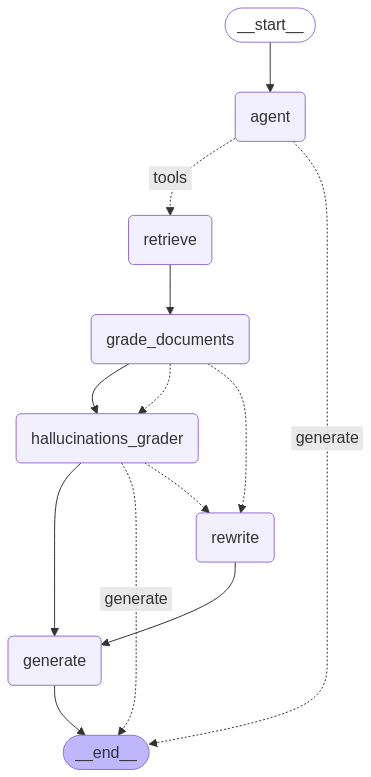

In [109]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [103]:
inputs = {
    "messages": [
        ("user", "Qui est Palantir ?")
    ]
}

for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=1, width=200, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2025-04-17T08:35:44.360051644Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3819239141, 'load_duration': 4622314, 'prompt_eval_count': 100, 'prompt_eval_duration': 347000000, 'eval_count': 154, 'eval_duration': 3466000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None), 'model_name': 'mistral'}, id='run-68ca46fd-7fa0-41e7-825c-d1f79b063589-0', tool_calls=[{'name': 'retrieve_apple_news', 'args': {'query': 'Palantir'}, 'id': '68839782-00c2-4c5e-b7f9-546f9fcef03a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 100, 'output_tokens': 154, 'total_tokens': 254})]}
'\n---\n'
"Output from node 'retrieve':"
'---'
{'messages': [ToolMessage(content='Still, for long-term, growth-oriented investors, Palantir is a name worth considering, given the soaring demand for its products and its i

In [104]:
inputs = {
    "messages": [
        ("user", "Quel est le lien entre Google et Palantir ?")
    ]
}

for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=1, width=200, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2025-04-17T08:35:51.309678963Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2782043906, 'load_duration': 4759577, 'prompt_eval_count': 106, 'prompt_eval_duration': 15000000, 'eval_count': 125, 'eval_duration': 2761000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None), 'model_name': 'mistral'}, id='run-76676ef3-1ca2-49b8-8792-5b424423a5d2-0', tool_calls=[{'name': 'retrieve_apple_news', 'args': {'query': 'Google Palantir partnership'}, 'id': '5ea5b13f-3d6e-4b25-9257-4f228f22ba17', 'type': 'tool_call'}], usage_metadata={'input_tokens': 106, 'output_tokens': 125, 'total_tokens': 231})]}
'\n---\n'
"Output from node 'retrieve':"
'---'
{'messages': [ToolMessage(content="Palantir operates AI-based analytics systems for governmental and commercial uses and is on the leading edge of translat

In [105]:
inputs = {
    "messages": [
        ("user", "Quel est le rapport entre Palantir et AAPL ?")
    ]
}

for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=1, width=200, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2025-04-17T08:36:06.204654443Z', 'done': True, 'done_reason': 'stop', 'total_duration': 8242059844, 'load_duration': 4832734, 'prompt_eval_count': 107, 'prompt_eval_duration': 15000000, 'eval_count': 364, 'eval_duration': 8220000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None), 'model_name': 'mistral'}, id='run-7b8cc15b-5bc2-4f60-afbd-f25a9158def7-0', tool_calls=[{'name': 'retrieve_apple_news', 'args': {'query': 'Palantir Apple Relationship'}, 'id': '24537bdc-e80d-4e28-90b6-6af9cc6b5add', 'type': 'tool_call'}], usage_metadata={'input_tokens': 107, 'output_tokens': 364, 'total_tokens': 471})]}
'\n---\n'
"Output from node 'retrieve':"
'---'
{'messages': [ToolMessage(content='Still, for long-term, growth-oriented investors, Palantir is a name worth considering, given the soaring demand for its 

In [113]:
inputs = {
    "messages": [
        ("user", "Qu'apprend-on sur Alphabet dans les articles fournis ?")
    ]
}

for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=1, width=200, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2025-04-17T09:05:20.510425074Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5062292980, 'load_duration': 9661876, 'prompt_eval_count': 108, 'prompt_eval_duration': 253000000, 'eval_count': 214, 'eval_duration': 4797000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None), 'model_name': 'mistral'}, id='run-303fa684-5682-475f-bfd0-2a88d30efa40-0', tool_calls=[{'name': 'retrieve_apple_news', 'args': {'query': 'Alphabet'}, 'id': '89c9aa4e-3702-48af-a40e-e66c8a98f917', 'type': 'tool_call'}], usage_metadata={'input_tokens': 108, 'output_tokens': 214, 'total_tokens': 322})]}
'\n---\n'
"Output from node 'retrieve':"
'---'
{'messages': [ToolMessage(content="Should you invest $1,000 in Alphabet right now?\nBefore you buy stock in Alphabet, consider this:\nThe Motley Fool Stock Advisor analyst t

In [107]:
inputs = {
    "messages": [
        ("user", "Qu'apprend-on sur Alphabet ?")
    ]
}

node_outputs = {}
for output in graph.stream(inputs):
    for key, value in output.items():
        node_outputs[key] = value
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

if "generate" in node_outputs:
    print("RÉPONSE FINALE (du nœud generate):")
    print(node_outputs["generate"])
elif "END" in node_outputs:
    print("RÉPONSE FINALE (du nœud END):")
    print(node_outputs["END"])

---CALL AGENT---
Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2025-04-17T08:36:29.073358446Z', 'done': True, 'done_reason': 'stop', 'total_duration': 9801259881, 'load_duration': 3818380, 'prompt_eval_count': 103, 'prompt_eval_duration': 5000000, 'eval_count': 437, 'eval_duration': 9790000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None), 'model_name': 'mistral'}, id='run-36632c3b-9dc7-4933-9b26-8814a5a7e24c-0', tool_calls=[{'name': 'retrieve_apple_news', 'args': {'query': 'Alphabet'}, 'id': 'bb1d66c8-cc43-46a8-99e1-493c0296160e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 103, 'output_tokens': 437, 'total_tokens': 540})]}

---

Output from node 'retrieve':
---
{'messages': [ToolMessage(content="Should you invest $1,000 in Alphabet right now?\nBefore you buy stock in Alphabet, consider this:\nThe Motley Fool Stock Advisor analyst team just ident